In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

/opt/homebrew/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Import Shapefiles

In [2]:
virtual = gpd.read_file('data_raw/virtual_country')
virtual.head()

,uniq_cnt25,point5_id,pop95,maize,pasture,suit_new,sorghum,allcrops,geometry
0,39,247867.0,0.0002,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-86.00000 82.00000, -86.50000 82.000..."
1,40,247868.0,0.0002,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-85.50000 82.00000, -86.00000 82.000..."
2,40,247869.0,0.0003,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-85.00000 82.00000, -85.50000 82.000..."
3,40,247870.0,0.0003,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-84.50000 82.00000, -85.00000 82.000..."
4,40,247871.0,0.0003,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-84.00000 82.00000, -84.50000 82.000..."


In [3]:
greg = gpd.read_file('greg')
greg.head()

,FIPS_CNTRY,GROUP1,GROUP2,GROUP3,G1ID,G2ID,G3ID,G1SHORTNAM,G2SHORTNAM,G3SHORTNAM,G1LONGNAM,G2LONGNAM,G3LONGNAM,FeatureID,AREA,COW,geometry
0,AA,12,0,0,312,0,0,Curaçao Islanders,None,None,Curaçao Islanders,None,None,0,2.007795e+08,0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,AC,16,0,0,354,0,0,English-speaking population of the Lesser Anti...,None,None,English-speaking population of the Lesser Anti...,None,None,1,5.398570e+08,58,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,AF,33,53,0,117,202,0,Baloch,Brahui,None,Baloch (Baluchis),Brahui,None,2,1.189781e+10,700,"POLYGON ((64.03937 30.02453, 64.03937 30.11267..."
3,AF,24,34,0,898,12,0,Persians,Afghans,None,Persians,"Afghans (Pushtuns, Pathans)",None,3,1.653610e+09,700,"POLYGON ((61.75456 30.78628, 61.75833 30.79028..."
4,AF,34,41,0,12,1051,0,Afghans,Tajiks,None,"Afghans (Pushtuns, Pathans)",Tajiks (Tadzhiks),None,4,3.251011e+09,700,"POLYGON ((61.62285 31.39536, 61.64841 31.46713..."


In [4]:
virtual.crs, greg.crs

(<Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Geographic 2D CRS: EPSG:4326>
 Name: WGS 84
 Axis Info [ellipsoidal]:
 - Lat[north]: Geodetic latitude (degree)
 - Lon[east]: Geodetic longitude (degree)
 Area of Use:
 - name: World.
 - bounds: (-180.0, -90.0, 180.0, 90.0)
 Datum: World Geodetic System 1984 ensemble
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

<AxesSubplot:>

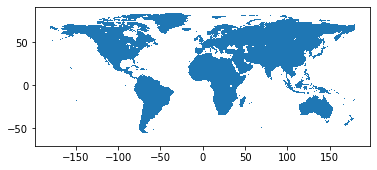

In [5]:
virtual.plot()

<AxesSubplot:>

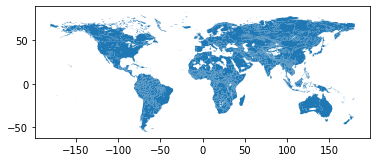

In [6]:
greg.plot()

## Transform GREG

The original GREG format is a number of regions, each of which has up to three ethnic groups attached to it. Ethnic groups may also be attached to different regions. This code chunk melts, and then dissolves, the original `greg` dataset, such that we have one entry per ethnic group.

In [7]:
melted = pd.melt(greg, id_vars = ['geometry'], value_vars = ['G1SHORTNAM', 'G2SHORTNAM', 'G3SHORTNAM'], value_name = 'SHORTNAM')
ethnicGroups = melted[melted['SHORTNAM'].notna()].drop('variable', axis = 1).dissolve(by = 'SHORTNAM', aggfunc = 'first', as_index = False)
ethnicGroups

,SHORTNAM,geometry
0,Abazinians,"MULTIPOLYGON (((41.83519 44.08370, 41.86445 44..."
1,Abkhaz,"MULTIPOLYGON (((41.73878 42.62086, 41.71329 42..."
2,Achaguas,"MULTIPOLYGON (((-74.02123 2.16973, -73.98634 2..."
3,Achang,"POLYGON ((97.84312 24.33767, 97.84467 24.36087..."
4,Achinese,"MULTIPOLYGON (((97.81446 2.77691, 97.86672 2.7..."
...,...,...
923,Zagawa,"MULTIPOLYGON (((25.88538 14.53904, 25.83321 14..."
924,Zakhchins,"POLYGON ((91.54557 47.36713, 91.54557 47.43751..."
925,Zapotecs,"POLYGON ((-94.96082 16.37316, -95.03084 16.322..."
926,Zoque,"MULTIPOLYGON (((-93.18895 16.87464, -93.13737 ..."


## Perform Intersection

This cell intersects the imported dataset of cells with the dataset of ethnic groups, derived from GREG.

In [8]:
joined = gpd.overlay(virtual, ethnicGroups, how = 'intersection')
joined.head()

,uniq_cnt25,point5_id,pop95,maize,pasture,suit_new,sorghum,allcrops,SHORTNAM,geometry
0,211,247281.0,0.0301,0.0,0.0,0.0000,0.0,0.0,Eskimos,"MULTIPOLYGON (((-19.00000 81.71801, -19.14417 ..."
1,211,247282.0,0.0300,0.0,0.0,0.0000,0.0,0.0,Eskimos,"MULTIPOLYGON (((-19.00000 81.80707, -18.99083 ..."
2,335,241416.0,0.0271,0.0,0.0,0.0001,0.0,0.0,Eskimos,"POLYGON ((-72.00000 78.00000, -71.87679 78.000..."
3,335,242134.0,0.0195,0.0,0.0,0.0001,0.0,0.0,Eskimos,"MULTIPOLYGON (((-73.00000 78.17449, -72.99834 ..."
4,335,242135.0,0.0330,0.0,0.0,0.0001,0.0,0.0,Eskimos,"POLYGON ((-72.34038 78.00000, -72.34695 78.003..."


<AxesSubplot:xlabel='SHORTNAM', ylabel='Count'>

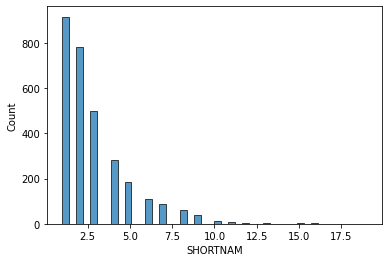

In [9]:
sns.histplot(x = joined.groupby('uniq_cnt25')['SHORTNAM'].nunique().sort_values())

In [10]:
joined.groupby('uniq_cnt25')['SHORTNAM'].nunique().to_csv('greg.csv')

## Complete Coverage

From the original paper: "each and every part of a virtual country that remains after the spatial intersection has complete linguistic coverage"

Due to the differences between GREG and the WLMS, this section attempts to see if there are any additional virtual countries that were excluded by Michalopoulos for not having complete coverage from WLMS, but do in fact have complete coverage with GREG, or the other way around.

Unfortunately, there are 262 additional virtual countries that are not included in the original data download, meaning we would have to reconstruct the variables for those countries. In addition, there are 803 countries included from WLMS that *do not* have full coverage in GREG.

In [11]:
joinedDissolved = joined[joined['SHORTNAM'].notna()].dissolve(by = 'uniq_cnt25')
joinedDissolved.head()

/opt/homebrew/lib/python3.9/site-packages/pygeos/set_operations.py:388: RuntimeWarning: divide by zero encountered in unary_union
  result = lib.unary_union(collections, **kwargs)


,geometry,point5_id,pop95,maize,pasture,suit_new,sorghum,allcrops,SHORTNAM
uniq_cnt25,,,,,,,,,
211,"MULTIPOLYGON (((-18.91028 81.80887, -18.83556 ...",247281.0,0.0301,0.0,0.0,0.0000,0.0,0.0,Eskimos
335,"POLYGON ((-71.98471 77.90229, -72.00000 77.906...",241416.0,0.0271,0.0,0.0,0.0001,0.0,0.0,Eskimos
336,"MULTIPOLYGON (((-70.84973 77.14526, -70.81361 ...",240698.0,0.0295,0.0,0.0,0.0001,0.0,0.0,Eskimos
356,"POLYGON ((-20.44473 77.00000, -20.00000 77.211...",240799.0,0.0330,0.0,0.0,0.0000,0.0,0.0,Eskimos
357,"POLYGON ((-18.50000 77.00000, -18.50000 77.347...",240803.0,0.0320,0.0,0.0,0.0000,0.0,0.0,Eskimos


In [12]:
virtualDissolved = virtual.dissolve(by = 'uniq_cnt25')
virtualDissolved.head()

,geometry,point5_id,pop95,maize,pasture,suit_new,sorghum,allcrops
uniq_cnt25,,,,,,,,
39,"POLYGON ((-86.00000 82.00000, -86.50000 82.000...",247867.0,0.0002,0.0,0.0,0.0,0.0,0.0
40,"POLYGON ((-86.00000 82.50000, -85.50000 82.500...",247868.0,0.0002,0.0,0.0,0.0,0.0,0.0
41,"POLYGON ((-83.50000 82.50000, -83.00000 82.500...",247873.0,0.0003,0.0,0.0,0.0,0.0,0.0
42,"POLYGON ((-78.50000 82.00000, -79.00000 82.000...",247878.0,0.0003,0.0,0.0,0.0,0.0,0.0
43,"POLYGON ((-76.00000 82.00000, -76.50000 82.000...",247883.0,0.0003,0.0,0.0,0.0,0.0,0.0


In [13]:
areas = joinedDissolved.area.reset_index().set_index('uniq_cnt25').rename(columns = {0: 'greg'})
areas['full'] = virtualDissolved.area
areas

/var/folders/l7/_yl1rg512jv095gql7v0v5r00000gn/T/ipykernel_82285/4143668804.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = joinedDissolved.area.reset_index().set_index('uniq_cnt25').rename(columns = {0: 'greg'})
/var/folders/l7/_yl1rg512jv095gql7v0v5r00000gn/T/ipykernel_82285/4143668804.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas['full'] = virtualDissolved.area


,greg,full
uniq_cnt25,,
211,0.073906,5.50
335,0.575864,2.00
336,0.863891,5.00
356,0.516579,4.25
357,0.104417,0.50
...,...,...
7881,0.181935,0.50
8020,0.399344,3.75
8021,1.756110,5.75


In [14]:
areas['count'] = joined.groupby('uniq_cnt25')['SHORTNAM'].nunique()

In [15]:
df = pd.read_stata('data_raw/Tables4-7b.dta')
df['uniq_cnt25'] = df['uniq_cnt25'].astype(int)
df.head()

,uniq_cnt25,wbcode_centroid,clim_suit,soil_suit,sdclim,sdsoil,sea_dist,emean,precav,tempav,...,tropics,erange_gecon,lnareakm2,lnmean_pop95,indigenous,diffemean,diffprecav,difftempav,diffavg,overlap
0,687,RUS,0.001554,0.508703,0.000107,0.017684,1.245290,0.134700,0.033053,-12.296000,...,0.0,0.064,0.615041,-10.844584,0.96,0.002367,0.000185,-0.025999,-0.000025,0.0
1,690,RUS,0.002942,0.537747,0.000533,0.097307,1.535823,0.069462,0.029442,-12.593077,...,0.0,0.041,1.679177,-9.123105,0.96,-0.029205,0.001050,0.418035,0.000062,0.0
2,696,RUS,0.005517,0.567190,0.000540,0.126735,2.094293,0.059067,0.019826,-13.622666,...,0.0,0.065,1.922477,-10.733601,0.96,-0.019933,0.000729,0.396222,0.000227,0.0
3,697,RUS,0.005504,0.513444,0.000640,0.097434,2.156625,0.078250,0.018673,-13.852500,...,0.0,0.088,1.240280,-10.733601,0.96,-0.018306,0.000229,0.249722,0.000077,0.0
4,698,RUS,0.005641,0.473895,0.000487,0.058877,2.144950,0.031600,0.017096,-13.879000,...,0.0,0.066,1.554200,-10.233104,0.96,-0.021400,-0.000535,-0.084714,-0.000057,0.0


In [16]:
areas.loc[np.isclose(areas['greg'], areas['full']) & (~areas.index.isin(df['uniq_cnt25']))]

,greg,full,count
uniq_cnt25,,,
691,6.250000,6.25,2
692,6.250000,6.25,2
693,6.250000,6.25,2
694,6.250000,6.25,2
695,6.250000,6.25,3
...,...,...,...
7152,6.249999,6.25,2
7153,6.250000,6.25,2
7296,6.250000,6.25,2


In [17]:
areas.loc[(~np.isclose(areas['greg'], areas['full'])) & (areas.index.isin(df['uniq_cnt25']))]

,greg,full,count
uniq_cnt25,,,
687,3.908607,5.00,1
696,6.056261,6.25,2
697,5.194727,6.25,2
698,4.715212,5.25,4
699,4.563275,5.50,3
...,...,...,...
7150,6.021838,6.25,4
7249,4.711367,5.25,1
7250,2.306446,2.75,2
